# Stochastic Gradient Descent with Learning Rate Schedules and Regularization

## Imports

In [4]:
import numpy as np
from sklearn.model_selection import *
from src.data import *
from src.helpers import test_model_performance, plot_performance_metrics

## Structure of SGD

In [5]:
class SGD:
    """Стохастический градиентный спуск для задач регрессии."""

    def __init__(self, learning_rate=0.01, epochs=100, batch_size=32,
                 regularization=None, reg_param=0.01, lr_schedule=None,
                 momentum=0.0, early_stopping=False, patience=10,
                 verbose=False, random_state=None):
        """
        Инициализация SGD с настройками

        Параметры:
        learning_rate : начальная скорость обучения
        epochs : количество эпох обучения
        batch_size : размер мини-батча
        regularization : тип регуляризации ('l1', 'l2', 'elasticnet')
        reg_param : параметр регуляризации (lambda)
        lr_schedule : график скорости обучения ('constant', 'time_decay', 'step_decay', 'exponential')
        momentum : коэффициент импульса (0 - без импульса)
        early_stopping : использовать раннюю остановку
        patience : количество эпох без улучшения для ранней остановки
        verbose : выводить информацию о процессе обучения
        random_state : значение для воспроизводимости результатов
        """
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.regularization = regularization
        self.reg_param = reg_param
        self.lr_schedule = lr_schedule
        self.momentum = momentum
        self.early_stopping = early_stopping
        self.patience = patience
        self.verbose = verbose

        self.random_state = random_state
        self.rng = np.random.RandomState(random_state)

        self.weights = None
        self.bias = None
        self.velocity_w = None
        self.velocity_b = None

        self.loss_history = []
        self.val_loss_history = []
        self.best_weights = None
        self.best_bias = None
        self.best_val_loss = float('inf')
        self.best_epoch = 0

    def _initialize_parameters(self, n_features):
        """Инициализация весов и смещения"""
        # Инициализация Xavier для лучшей сходимости
        limit = np.sqrt(6 / (n_features + 1))
        self.weights = self.rng.uniform(-limit, limit, n_features)
        self.bias = 0.0

        # Инициализация для импульса
        self.velocity_w = np.zeros(n_features)
        self.velocity_b = 0.0

        # Для early stopping
        self.best_weights = self.weights.copy()
        self.best_bias = self.bias

    def _get_learning_rate(self, epoch):
        """Расчет скорости обучения в зависимости от графика"""
        if self.lr_schedule is None or self.lr_schedule == 'constant':
            return self.learning_rate

        if self.lr_schedule == 'time_decay':
            decay_rate = 0.01
            return self.learning_rate / (1 + decay_rate * epoch)

        if self.lr_schedule == 'step_decay':
            drop = 0.5
            epochs_drop = 10
            return self.learning_rate * np.power(drop, np.floor(epoch / epochs_drop))

        if self.lr_schedule == 'exponential':
            decay_rate = 0.01
            return self.learning_rate * np.exp(-decay_rate * epoch)

        return self.learning_rate

    def _apply_regularization(self, weights, gradient):
        """Применение регуляризации к градиенту"""
        if self.regularization is None:
            return gradient

        if self.regularization == 'l2':
            return gradient + self.reg_param * weights

        if self.regularization == 'l1':
            return gradient + self.reg_param * np.sign(weights)

        if self.regularization == 'elasticnet':
            l1_ratio = 0.5
            l1_contrib = self.reg_param * l1_ratio * np.sign(weights)
            l2_contrib = self.reg_param * (1 - l1_ratio) * weights
            return gradient + l1_contrib + l2_contrib

        return gradient

    def _compute_gradient(self, X_batch, y_batch):
        """Вычисление градиента для мини-батча"""
        m = X_batch.shape[0]
        predictions = X_batch @ self.weights + self.bias  # оптимизировано
        errors = predictions - y_batch

        # Оптимизированное вычисление градиента
        dw = (X_batch.T @ errors) / m
        db = np.mean(errors)

        # Применение регуляризации только к весам
        dw = self._apply_regularization(self.weights, dw)

        return dw, db

    def fit(self, X, y, X_val=None, y_val=None):
        """
        Обучение модели на данных
        """
        X = np.asarray(X)
        y = np.asarray(y)

        if X_val is not None:
            X_val = np.asarray(X_val)
            y_val = np.asarray(y_val)
            use_validation = True
        else:
            use_validation = False

        n_samples, n_features = X.shape
        self._initialize_parameters(n_features)

        self.loss_history = []
        self.val_loss_history = []
        no_improvement_count = 0

        for epoch in range(self.epochs):
            # Перемешиваем данные на каждой эпохе
            indices = self.rng.permutation(n_samples)
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            # Текущая скорость обучения
            current_lr = self._get_learning_rate(epoch)

            # Мини-батч SGD
            for i in range(0, n_samples, self.batch_size):
                end_idx = min(i + self.batch_size, n_samples)
                X_batch = X_shuffled[i:end_idx]
                y_batch = y_shuffled[i:end_idx]

                # Вычисление градиентов
                dw, db = self._compute_gradient(X_batch, y_batch)

                # Обновление с использованием импульса
                self.velocity_w = self.momentum * self.velocity_w - current_lr * dw
                self.velocity_b = self.momentum * self.velocity_b - current_lr * db

                # Обновление параметров
                self.weights += self.velocity_w
                self.bias += self.velocity_b

            # Расчет ошибки на обучающей выборке
            train_predictions = X @ self.weights + self.bias
            train_loss = np.mean((train_predictions - y) ** 2)
            self.loss_history.append(train_loss)

            # Расчет ошибки на валидационной выборке
            if use_validation:
                val_predictions = X_val @ self.weights + self.bias
                val_loss = np.mean((val_predictions - y_val) ** 2)
                self.val_loss_history.append(val_loss)

                # Сохраняем лучшие веса
                if val_loss < self.best_val_loss:
                    self.best_val_loss = val_loss
                    self.best_weights = self.weights.copy()
                    self.best_bias = self.bias
                    self.best_epoch = epoch
                    no_improvement_count = 0
                else:
                    no_improvement_count += 1

            # Вывод прогресса
            if self.verbose and (epoch + 1) % 10 == 0:
                status = f"Эпоха {epoch + 1}/{self.epochs}, loss: {train_loss:.6f}"
                if use_validation:
                    status += f", val_loss: {val_loss:.6f}"
                print(status)

            # Ранняя остановка
            if self.early_stopping and use_validation and no_improvement_count >= self.patience:
                if self.verbose:
                    print(f"Ранняя остановка на эпохе {epoch + 1}")
                # Восстанавливаем лучшие веса
                self.weights = self.best_weights
                self.bias = self.best_bias
                break

        # Восстанавливаем лучшие веса в конце обучения
        if use_validation:
            self.weights = self.best_weights
            self.bias = self.best_bias

        return self

    def predict(self, X):
        """Выполнение прогноза"""
        X = np.asarray(X)
        return X @ self.weights + self.bias

[I 2025-05-18 20:36:03,194] A new study created in memory with name: no-name-911cb69b-9893-4c68-9be6-fc2a8cec9be6


  0%|          | 0/8 [00:00<?, ?it/s]

[I 2025-05-18 20:36:03,201] Trial 0 finished with value: 1.5981984713269066e+95 and parameters: {}. Best is trial 0 with value: 1.5981984713269066e+95.
[I 2025-05-18 20:36:03,206] Trial 1 finished with value: 15529.175841569135 and parameters: {}. Best is trial 1 with value: 15529.175841569135.
[I 2025-05-18 20:36:03,212] Trial 2 finished with value: 0.5456530418838829 and parameters: {}. Best is trial 2 with value: 0.5456530418838829.
[I 2025-05-18 20:36:03,217] Trial 3 finished with value: 0.5599015081141603 and parameters: {}. Best is trial 2 with value: 0.5456530418838829.
[I 2025-05-18 20:36:03,221] Trial 4 finished with value: 0.5508099415724433 and parameters: {}. Best is trial 2 with value: 0.5456530418838829.
[I 2025-05-18 20:36:03,225] Trial 5 finished with value: 0.6364664058140939 and parameters: {}. Best is trial 2 with value: 0.5456530418838829.
[I 2025-05-18 20:36:03,229] Trial 6 finished with value: 0.7291795927251288 and parameters: {}. Best is trial 2 with value: 0.54

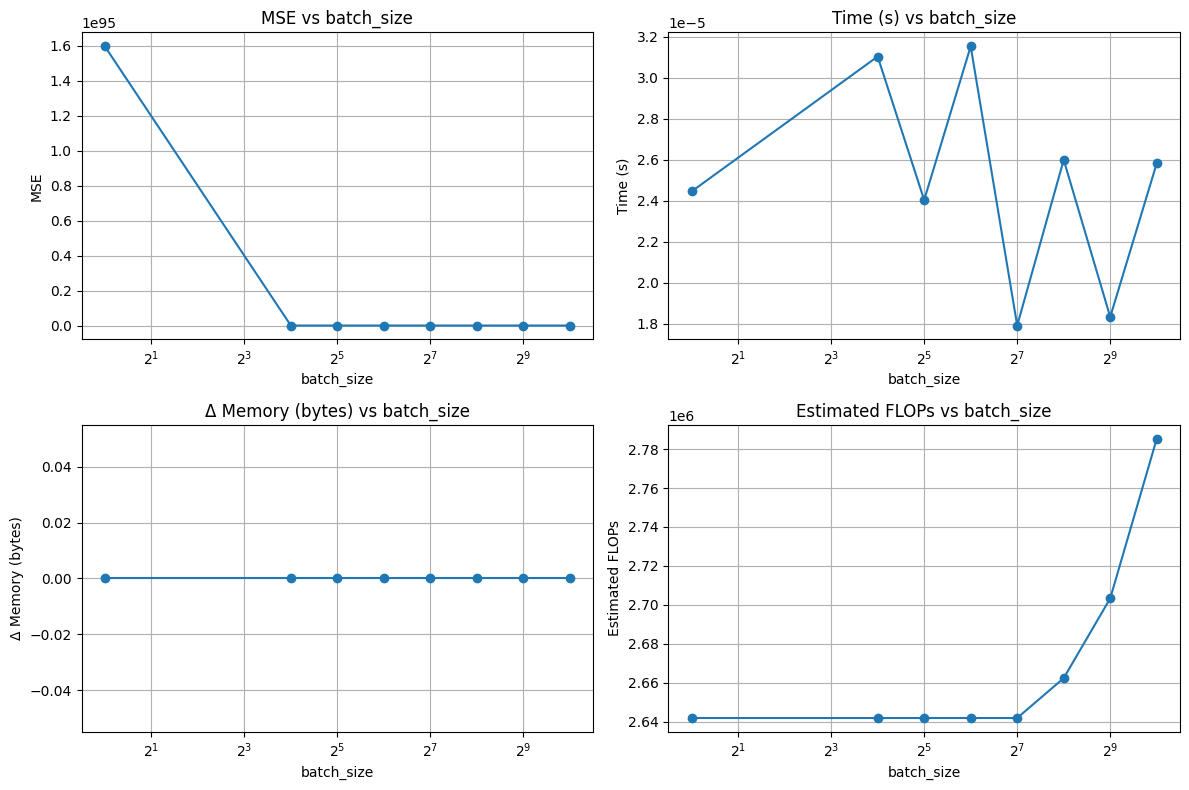

[I 2025-05-18 20:36:04,730] A new study created in memory with name: no-name-dc5ca5f4-27e9-418b-b2a2-e8b54beb3138


  0%|          | 0/8 [00:00<?, ?it/s]

[I 2025-05-18 20:36:04,738] Trial 0 finished with value: 1.0337886770494334e+95 and parameters: {}. Best is trial 0 with value: 1.0337886770494334e+95.
[I 2025-05-18 20:36:04,743] Trial 1 finished with value: 3332.6632740588943 and parameters: {}. Best is trial 1 with value: 3332.6632740588943.
[I 2025-05-18 20:36:04,749] Trial 2 finished with value: 0.5489567359936118 and parameters: {}. Best is trial 2 with value: 0.5489567359936118.
[I 2025-05-18 20:36:04,753] Trial 3 finished with value: 0.5568169938460092 and parameters: {}. Best is trial 2 with value: 0.5489567359936118.
[I 2025-05-18 20:36:04,758] Trial 4 finished with value: 0.5761139950962108 and parameters: {}. Best is trial 2 with value: 0.5489567359936118.
[I 2025-05-18 20:36:04,763] Trial 5 finished with value: 0.5641179237900136 and parameters: {}. Best is trial 2 with value: 0.5489567359936118.
[I 2025-05-18 20:36:04,767] Trial 6 finished with value: 0.6440116496474904 and parameters: {}. Best is trial 2 with value: 0.54

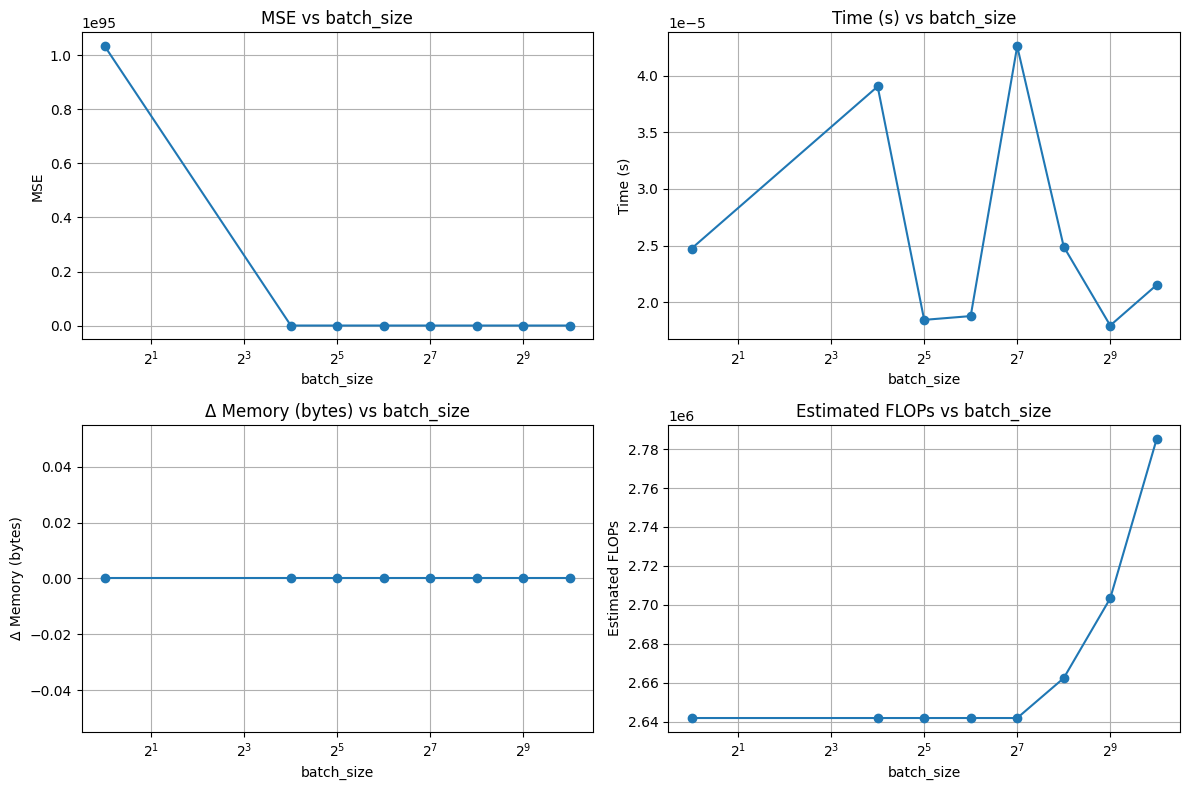

[I 2025-05-18 20:36:06,262] A new study created in memory with name: no-name-800edfa9-4e68-4f94-9844-6c5bf2f35452


  0%|          | 0/8 [00:00<?, ?it/s]

[I 2025-05-18 20:36:06,271] Trial 0 finished with value: 2.0207462339517276e+95 and parameters: {}. Best is trial 0 with value: 2.0207462339517276e+95.
[I 2025-05-18 20:36:06,276] Trial 1 finished with value: 333.0936819864233 and parameters: {}. Best is trial 1 with value: 333.0936819864233.
[I 2025-05-18 20:36:06,282] Trial 2 finished with value: 0.5506792197734477 and parameters: {}. Best is trial 2 with value: 0.5506792197734477.
[I 2025-05-18 20:36:06,287] Trial 3 finished with value: 0.5526817243846911 and parameters: {}. Best is trial 2 with value: 0.5506792197734477.
[I 2025-05-18 20:36:06,291] Trial 4 finished with value: 0.5592926158263314 and parameters: {}. Best is trial 2 with value: 0.5506792197734477.
[I 2025-05-18 20:36:06,296] Trial 5 finished with value: 0.6062450674820511 and parameters: {}. Best is trial 2 with value: 0.5506792197734477.
[I 2025-05-18 20:36:06,301] Trial 6 finished with value: 0.5630195342995427 and parameters: {}. Best is trial 2 with value: 0.5506

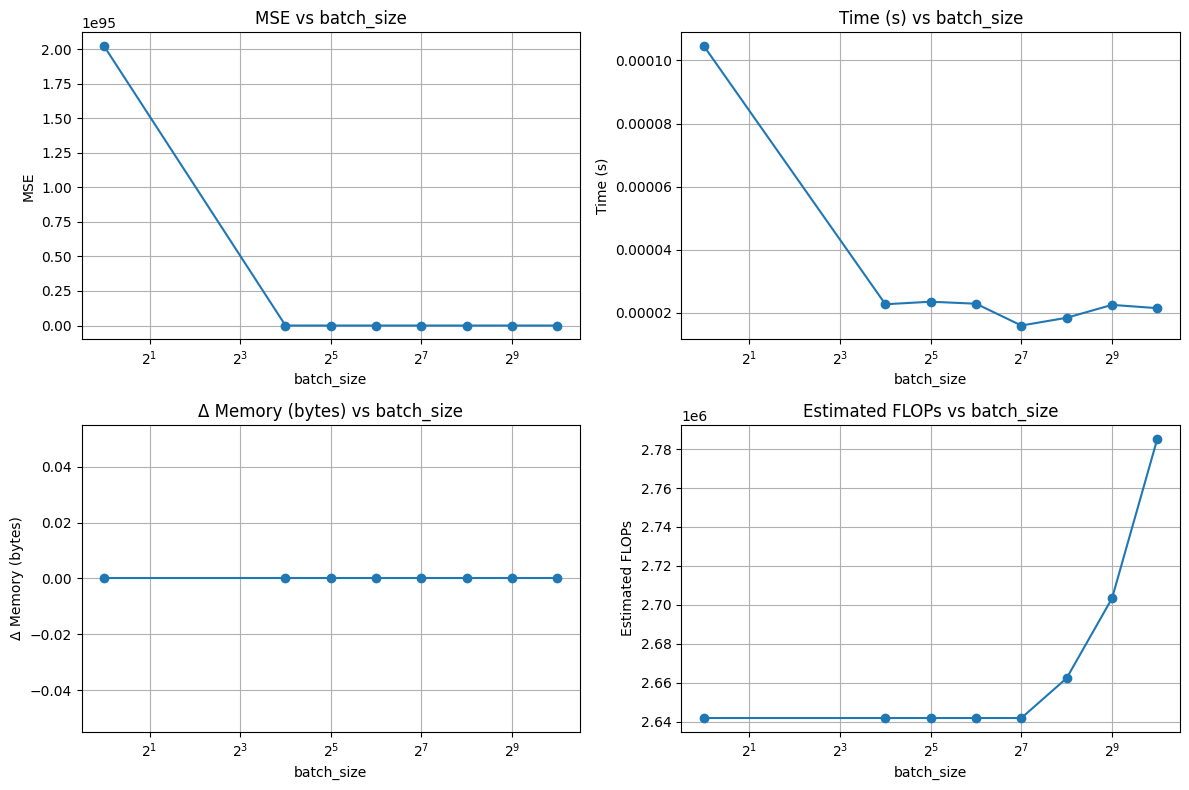

[I 2025-05-18 20:36:07,732] A new study created in memory with name: no-name-e5452103-6325-4f73-80c5-c28ff15567ff


  0%|          | 0/8 [00:00<?, ?it/s]

[I 2025-05-18 20:36:07,740] Trial 0 finished with value: 7.74753016028979e+92 and parameters: {}. Best is trial 0 with value: 7.74753016028979e+92.
[I 2025-05-18 20:36:07,745] Trial 1 finished with value: 773.0275064542902 and parameters: {}. Best is trial 1 with value: 773.0275064542902.
[I 2025-05-18 20:36:07,751] Trial 2 finished with value: 0.5520418590141689 and parameters: {}. Best is trial 2 with value: 0.5520418590141689.
[I 2025-05-18 20:36:07,756] Trial 3 finished with value: 0.5615013205400755 and parameters: {}. Best is trial 2 with value: 0.5520418590141689.
[I 2025-05-18 20:36:07,760] Trial 4 finished with value: 0.5576251740097166 and parameters: {}. Best is trial 2 with value: 0.5520418590141689.
[I 2025-05-18 20:36:07,764] Trial 5 finished with value: 0.6789245441043236 and parameters: {}. Best is trial 2 with value: 0.5520418590141689.
[I 2025-05-18 20:36:07,769] Trial 6 finished with value: 0.6400491157009194 and parameters: {}. Best is trial 2 with value: 0.55204185

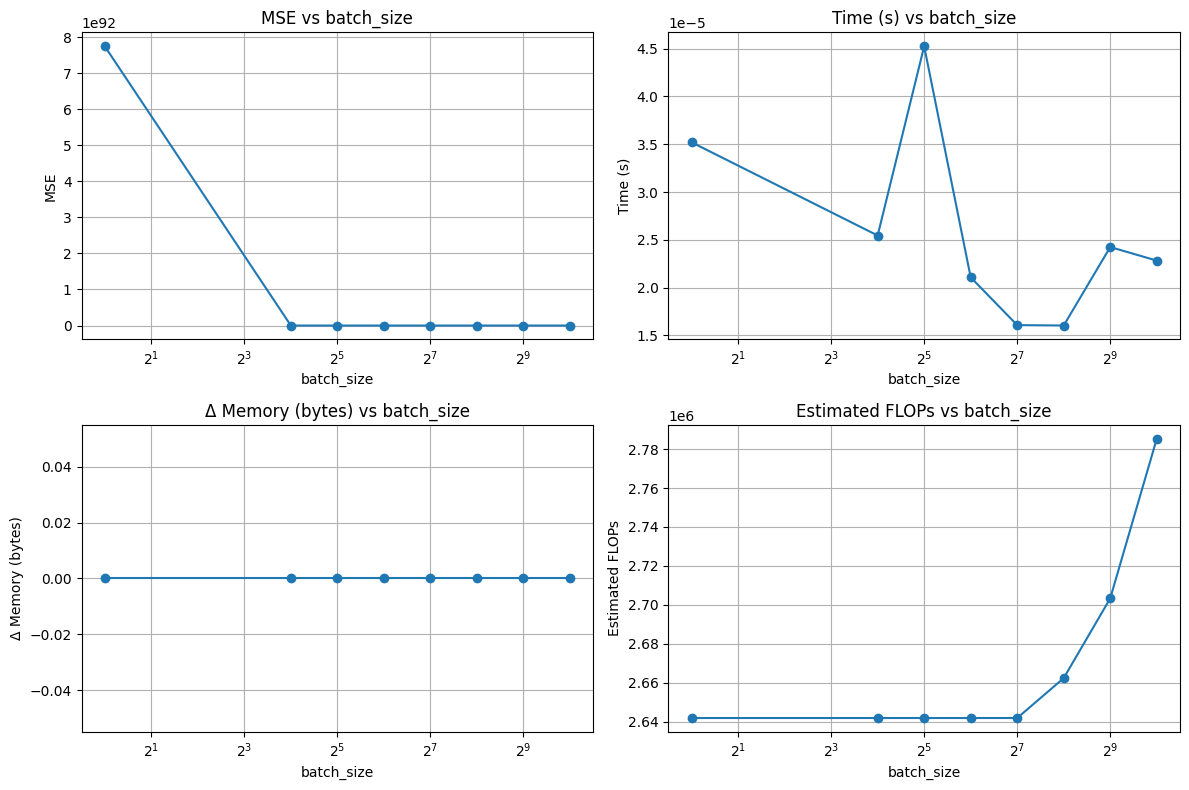

[I 2025-05-18 20:36:09,211] A new study created in memory with name: no-name-531bc9b0-685b-4e70-af50-c1d346cbb20b


  0%|          | 0/8 [00:00<?, ?it/s]

[I 2025-05-18 20:36:09,219] Trial 0 finished with value: 5.797346386161372e+81 and parameters: {}. Best is trial 0 with value: 5.797346386161372e+81.
[I 2025-05-18 20:36:09,224] Trial 1 finished with value: 44698.56457741886 and parameters: {}. Best is trial 1 with value: 44698.56457741886.
[I 2025-05-18 20:36:09,230] Trial 2 finished with value: 0.559190238426944 and parameters: {}. Best is trial 2 with value: 0.559190238426944.
[I 2025-05-18 20:36:09,236] Trial 3 finished with value: 0.5544940393710662 and parameters: {}. Best is trial 3 with value: 0.5544940393710662.
[I 2025-05-18 20:36:09,241] Trial 4 finished with value: 0.5471245903280081 and parameters: {}. Best is trial 4 with value: 0.5471245903280081.
[I 2025-05-18 20:36:09,245] Trial 5 finished with value: 0.5884007884018028 and parameters: {}. Best is trial 4 with value: 0.5471245903280081.
[I 2025-05-18 20:36:09,249] Trial 6 finished with value: 0.6143943181564437 and parameters: {}. Best is trial 4 with value: 0.54712459

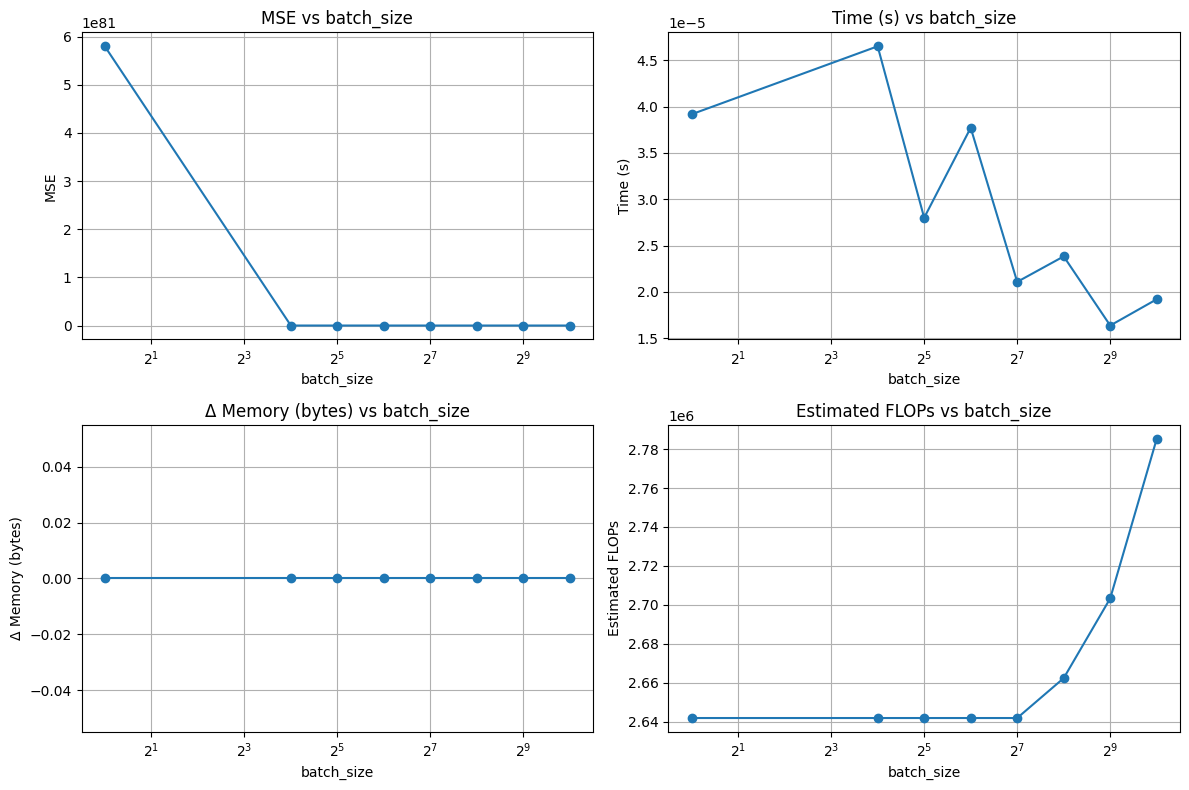

[I 2025-05-18 20:36:10,614] A new study created in memory with name: no-name-30db90dd-d2a9-4e9e-8526-dd8bfcc35765


  0%|          | 0/8 [00:00<?, ?it/s]

[I 2025-05-18 20:36:10,622] Trial 0 finished with value: 1.1910967468355007e+80 and parameters: {}. Best is trial 0 with value: 1.1910967468355007e+80.
[I 2025-05-18 20:36:10,628] Trial 1 finished with value: 611.672326604976 and parameters: {}. Best is trial 1 with value: 611.672326604976.
[I 2025-05-18 20:36:10,635] Trial 2 finished with value: 0.5490668773069596 and parameters: {}. Best is trial 2 with value: 0.5490668773069596.
[I 2025-05-18 20:36:10,640] Trial 3 finished with value: 0.5513335813886893 and parameters: {}. Best is trial 2 with value: 0.5490668773069596.
[I 2025-05-18 20:36:10,644] Trial 4 finished with value: 0.5904129248324436 and parameters: {}. Best is trial 2 with value: 0.5490668773069596.
[I 2025-05-18 20:36:10,648] Trial 5 finished with value: 0.5906817379466536 and parameters: {}. Best is trial 2 with value: 0.5490668773069596.
[I 2025-05-18 20:36:10,652] Trial 6 finished with value: 0.7149719283102811 and parameters: {}. Best is trial 2 with value: 0.549066

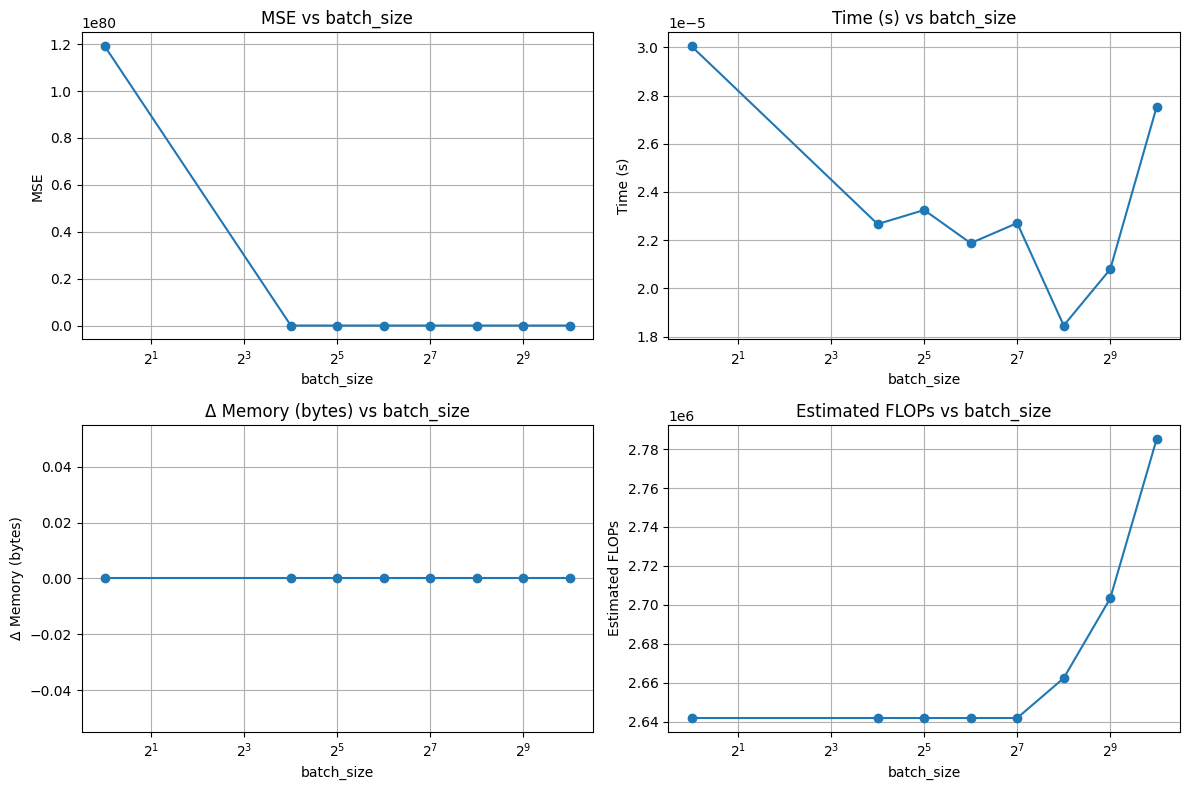

[I 2025-05-18 20:36:12,041] A new study created in memory with name: no-name-c15bd60e-83b1-464f-930b-0a8449481add


  0%|          | 0/8 [00:00<?, ?it/s]

[I 2025-05-18 20:36:12,049] Trial 0 finished with value: 1.2693501541289865e+78 and parameters: {}. Best is trial 0 with value: 1.2693501541289865e+78.
[I 2025-05-18 20:36:12,057] Trial 1 finished with value: 120920.0060660718 and parameters: {}. Best is trial 1 with value: 120920.0060660718.
[I 2025-05-18 20:36:12,063] Trial 2 finished with value: 0.561953342379563 and parameters: {}. Best is trial 2 with value: 0.561953342379563.
[I 2025-05-18 20:36:12,068] Trial 3 finished with value: 0.5457984185284517 and parameters: {}. Best is trial 3 with value: 0.5457984185284517.
[I 2025-05-18 20:36:12,073] Trial 4 finished with value: 0.5661551291591389 and parameters: {}. Best is trial 3 with value: 0.5457984185284517.
[I 2025-05-18 20:36:12,077] Trial 5 finished with value: 0.5984476131511391 and parameters: {}. Best is trial 3 with value: 0.5457984185284517.
[I 2025-05-18 20:36:12,081] Trial 6 finished with value: 0.7173048393828976 and parameters: {}. Best is trial 3 with value: 0.545798

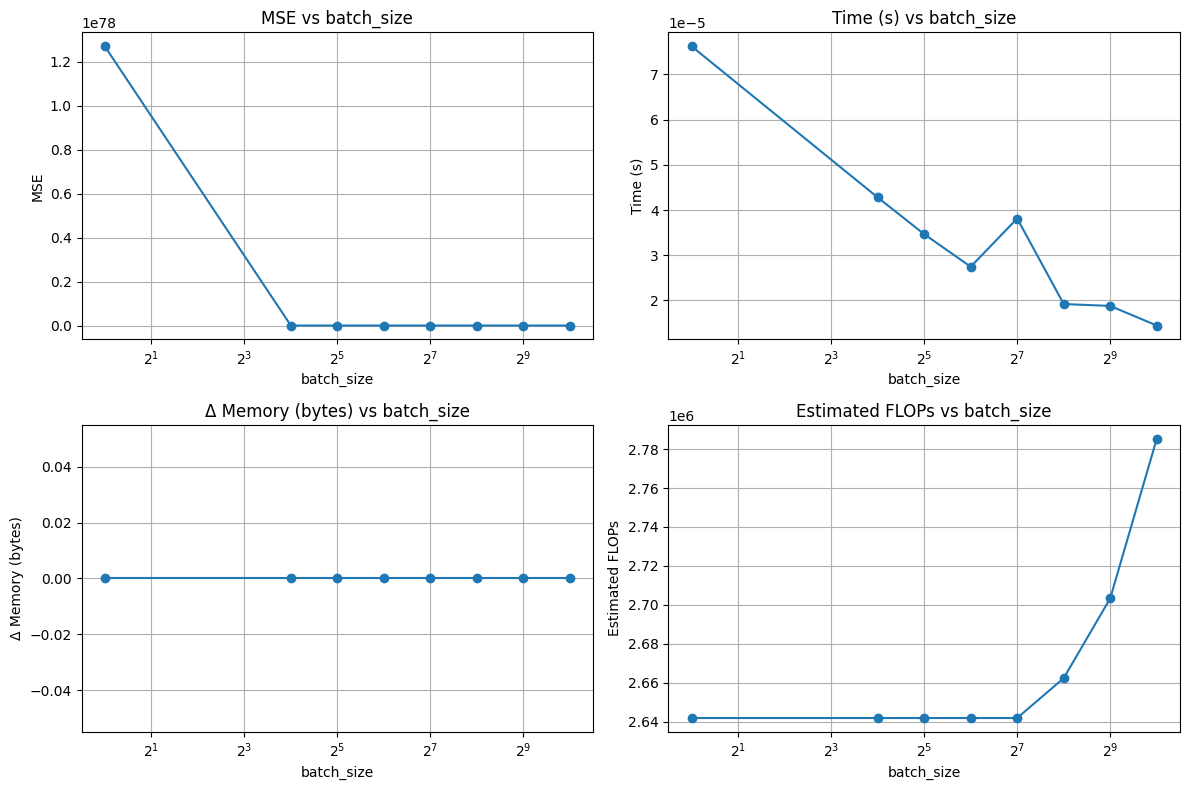

[I 2025-05-18 20:36:13,467] A new study created in memory with name: no-name-d8c76a97-24f3-41a9-a21e-b01995cf6fb5


  0%|          | 0/8 [00:00<?, ?it/s]

[I 2025-05-18 20:36:13,475] Trial 0 finished with value: 7.502834744494486e+80 and parameters: {}. Best is trial 0 with value: 7.502834744494486e+80.
[I 2025-05-18 20:36:13,480] Trial 1 finished with value: 157.97033292300662 and parameters: {}. Best is trial 1 with value: 157.97033292300662.
[I 2025-05-18 20:36:13,487] Trial 2 finished with value: 0.5834046060559288 and parameters: {}. Best is trial 2 with value: 0.5834046060559288.
[I 2025-05-18 20:36:13,491] Trial 3 finished with value: 0.5534404601175834 and parameters: {}. Best is trial 3 with value: 0.5534404601175834.
[I 2025-05-18 20:36:13,498] Trial 4 finished with value: 0.5667580678083082 and parameters: {}. Best is trial 3 with value: 0.5534404601175834.
[I 2025-05-18 20:36:13,503] Trial 5 finished with value: 0.6448518855960379 and parameters: {}. Best is trial 3 with value: 0.5534404601175834.
[I 2025-05-18 20:36:13,508] Trial 6 finished with value: 0.597011941652048 and parameters: {}. Best is trial 3 with value: 0.55344

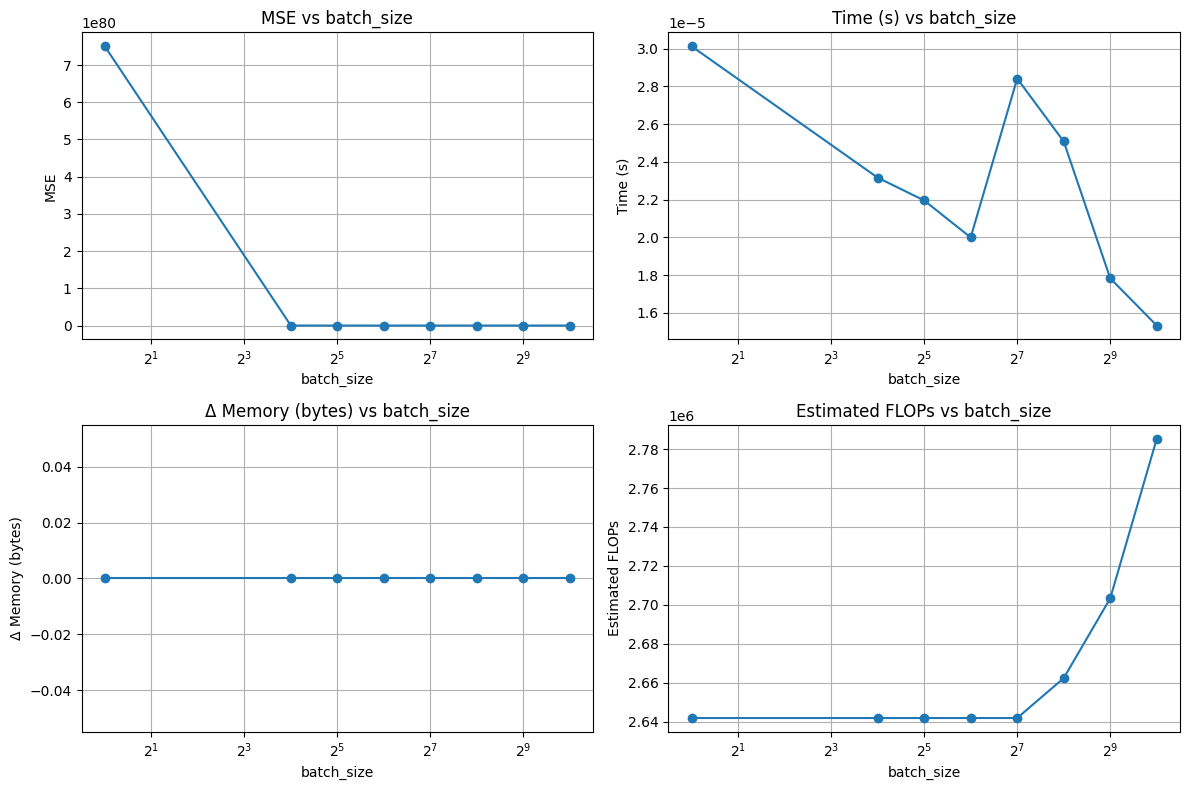

[I 2025-05-18 20:36:15,043] A new study created in memory with name: no-name-d307f215-dc55-4cf8-b1db-3948ab6268c4


  0%|          | 0/8 [00:00<?, ?it/s]

[I 2025-05-18 20:36:15,050] Trial 0 finished with value: 5.760784345936459e+87 and parameters: {}. Best is trial 0 with value: 5.760784345936459e+87.
[I 2025-05-18 20:36:15,056] Trial 1 finished with value: 112595.27156848056 and parameters: {}. Best is trial 1 with value: 112595.27156848056.
[I 2025-05-18 20:36:15,064] Trial 2 finished with value: 0.6014547205754448 and parameters: {}. Best is trial 2 with value: 0.6014547205754448.
[I 2025-05-18 20:36:15,081] Trial 3 finished with value: 0.5581384168370624 and parameters: {}. Best is trial 3 with value: 0.5581384168370624.
[I 2025-05-18 20:36:15,086] Trial 4 finished with value: 0.555747752182409 and parameters: {}. Best is trial 4 with value: 0.555747752182409.
[I 2025-05-18 20:36:15,090] Trial 5 finished with value: 0.5906063291131509 and parameters: {}. Best is trial 4 with value: 0.555747752182409.
[I 2025-05-18 20:36:15,094] Trial 6 finished with value: 0.6467693970350249 and parameters: {}. Best is trial 4 with value: 0.5557477

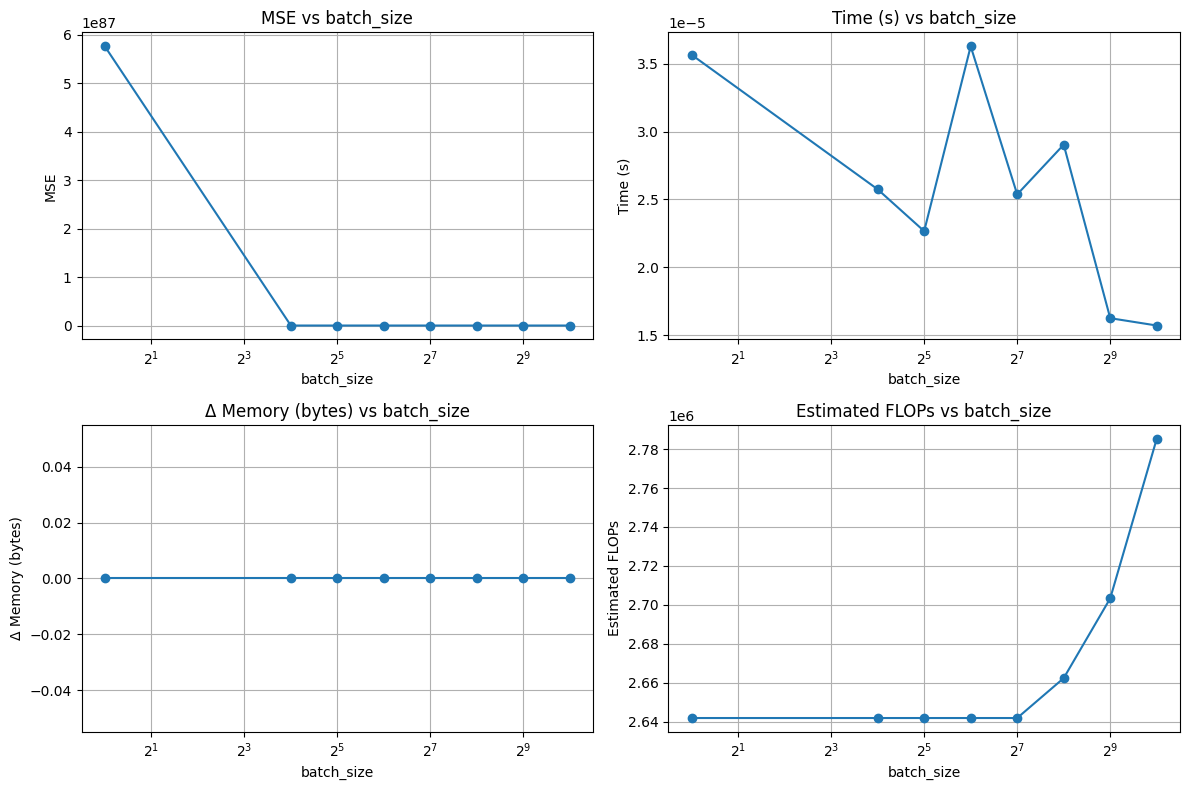

[I 2025-05-18 20:36:16,663] A new study created in memory with name: no-name-a2339f9e-507a-4387-879e-9c2784fef095


  0%|          | 0/8 [00:00<?, ?it/s]

[I 2025-05-18 20:36:16,671] Trial 0 finished with value: 9.826858197241593e+85 and parameters: {}. Best is trial 0 with value: 9.826858197241593e+85.
[I 2025-05-18 20:36:16,676] Trial 1 finished with value: 2095.240975811046 and parameters: {}. Best is trial 1 with value: 2095.240975811046.
[I 2025-05-18 20:36:16,683] Trial 2 finished with value: 0.54986571563836 and parameters: {}. Best is trial 2 with value: 0.54986571563836.
[I 2025-05-18 20:36:16,688] Trial 3 finished with value: 0.5524804615430071 and parameters: {}. Best is trial 2 with value: 0.54986571563836.
[I 2025-05-18 20:36:16,693] Trial 4 finished with value: 0.5641406530252112 and parameters: {}. Best is trial 2 with value: 0.54986571563836.
[I 2025-05-18 20:36:16,697] Trial 5 finished with value: 0.625609540275874 and parameters: {}. Best is trial 2 with value: 0.54986571563836.
[I 2025-05-18 20:36:16,702] Trial 6 finished with value: 0.6791131538184456 and parameters: {}. Best is trial 2 with value: 0.54986571563836.
[

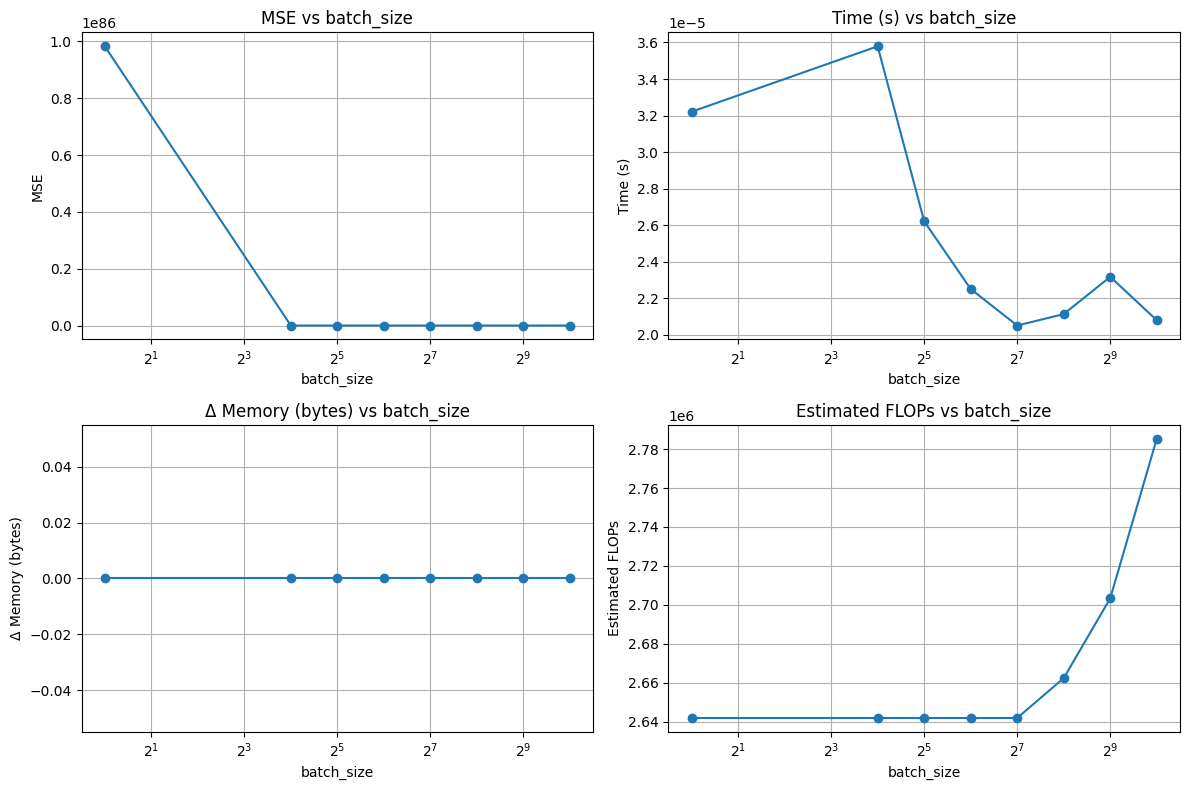

[I 2025-05-18 20:36:18,290] A new study created in memory with name: no-name-68d898c3-3188-4f58-af60-2092a851601d


  0%|          | 0/8 [00:00<?, ?it/s]

[I 2025-05-18 20:36:18,297] Trial 0 finished with value: 1.7772825402863958e+87 and parameters: {}. Best is trial 0 with value: 1.7772825402863958e+87.
[I 2025-05-18 20:36:18,303] Trial 1 finished with value: 15973.911448644341 and parameters: {}. Best is trial 1 with value: 15973.911448644341.
[I 2025-05-18 20:36:18,311] Trial 2 finished with value: 0.5545176979885159 and parameters: {}. Best is trial 2 with value: 0.5545176979885159.
[I 2025-05-18 20:36:18,317] Trial 3 finished with value: 0.5535597896002274 and parameters: {}. Best is trial 3 with value: 0.5535597896002274.
[I 2025-05-18 20:36:18,323] Trial 4 finished with value: 0.5585046365633062 and parameters: {}. Best is trial 3 with value: 0.5535597896002274.
[I 2025-05-18 20:36:18,329] Trial 5 finished with value: 0.6211884465340081 and parameters: {}. Best is trial 3 with value: 0.5535597896002274.
[I 2025-05-18 20:36:18,335] Trial 6 finished with value: 0.6265212704765691 and parameters: {}. Best is trial 3 with value: 0.55

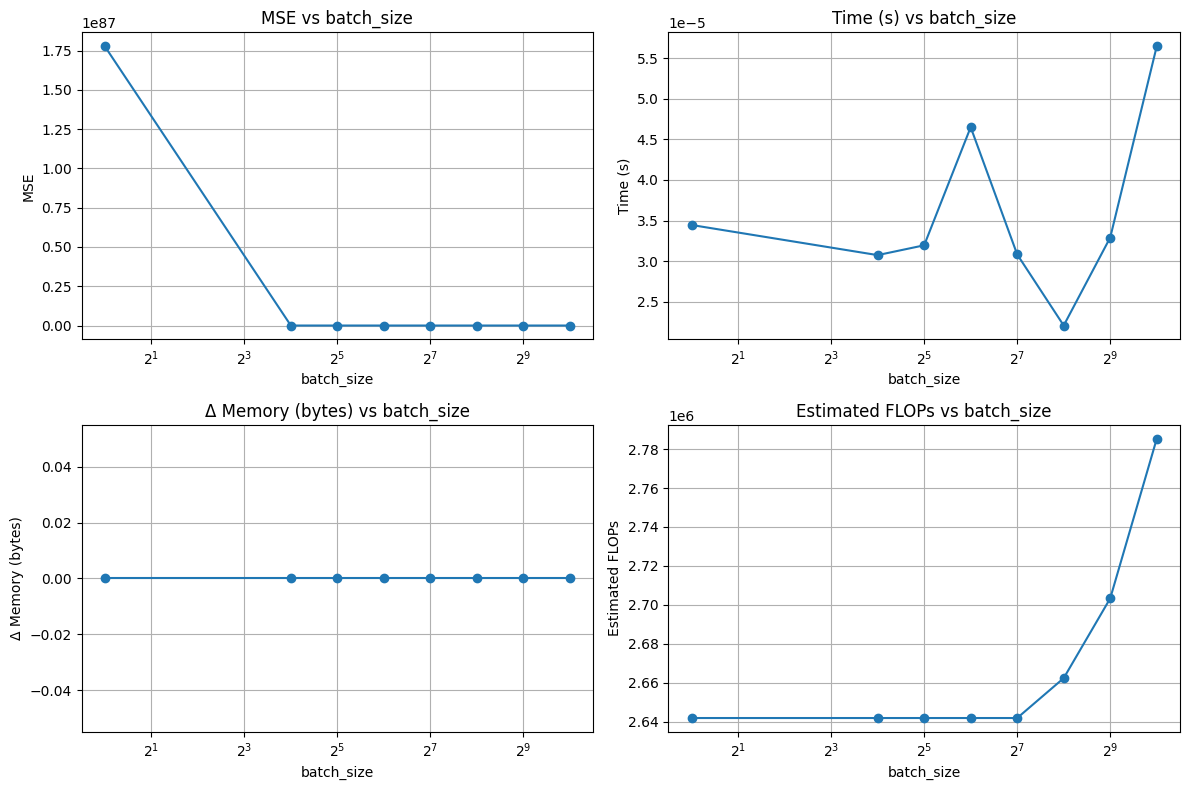

[I 2025-05-18 20:36:20,000] A new study created in memory with name: no-name-70f458f8-a514-47e5-a4bd-9d893d78c129


  0%|          | 0/8 [00:00<?, ?it/s]

[I 2025-05-18 20:36:20,008] Trial 0 finished with value: 8.746914149091341e+84 and parameters: {}. Best is trial 0 with value: 8.746914149091341e+84.
[I 2025-05-18 20:36:20,013] Trial 1 finished with value: 18.954477967012625 and parameters: {}. Best is trial 1 with value: 18.954477967012625.
[I 2025-05-18 20:36:20,019] Trial 2 finished with value: 0.5437546517239685 and parameters: {}. Best is trial 2 with value: 0.5437546517239685.
[I 2025-05-18 20:36:20,025] Trial 3 finished with value: 0.5507870781116732 and parameters: {}. Best is trial 2 with value: 0.5437546517239685.
[I 2025-05-18 20:36:20,029] Trial 4 finished with value: 0.5757458576364529 and parameters: {}. Best is trial 2 with value: 0.5437546517239685.
[I 2025-05-18 20:36:20,033] Trial 5 finished with value: 0.6698983258639116 and parameters: {}. Best is trial 2 with value: 0.5437546517239685.
[I 2025-05-18 20:36:20,038] Trial 6 finished with value: 0.6793126118755813 and parameters: {}. Best is trial 2 with value: 0.5437

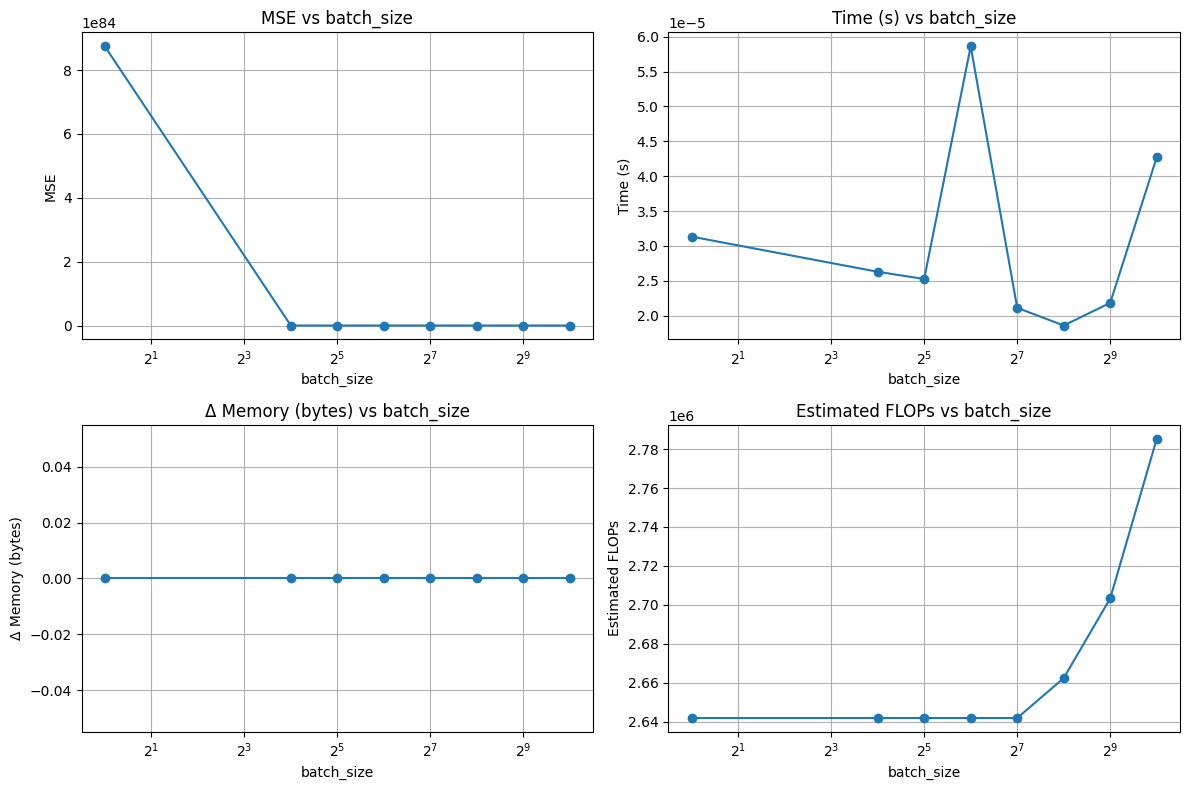

In [6]:
def bench(reg, lrs):
    models = []
    for batch_size in [1, 16, 32, 64, 128, 256, 512, 1024]:
        X, y = load_california(scale=True)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        model = SGD(
            learning_rate=0.01,
            epochs=10,
            batch_size=batch_size,
            regularization=reg,
            reg_param=0.01,
            lr_schedule=lrs
        )
        model.fit(X_train, y_train)
        models.append(model)

    plot_performance_metrics(models)

for reg in ['l1', 'l2', 'elasticnet']:
    for lrs in ['constant', 'time_decay', 'step_decay', 'exponential']:
        bench(reg, lrs)